# Data Processing Technical Details

In [ ]:

"""
Preprocessing, Feature Engineering, and Dimensionality Reduction Pipeline

This section implements a comprehensive data processing pipeline for analyzing hospital bed
utilization rates using social determinants of health (SDOH) and geographic access features.
The pipeline consists of the following major components:

Data Loading and Initial Exploration:
- Loads the merged dataset MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv
- Performs initial data quality checks and exploratory analysis
- Examines missing value patterns across features
- Provides summary statistics and data type information

Preprocessing and Filtering:
- Removes Washington D.C. from the dataset due to its unique characteristics
- Drops Region rows with missing values
- Removes Land_area_sqmi and Pct_renter_cost_30pct_plus features
- Separates modeling dataset (with non-missing target) from rows with missing targets

Feature Engineering and Encoding:
- Applies one-hot encoding to the Region categorical variable (South, West, Northeast)
- Converts Is_Metro_Micro to binary format (0/1)
- Implements standardization for all numerical features
- Uses KNN imputation (5 neighbors) for missing Is_Metro_Micro values
- Preserves original data shape by keeping missing target values separate

Data Export and Integration:
- Creates two structured Excel outputs:
  1. final_full_dataset_with_preserved_missing_targets.xlsx - full dataset
  2. modeling_dataset_only.xlsx - complete cases for modeling
- Maintains data integrity by preserving original indices

Evaluation and Visualization:
- Generates distribution comparisons (train vs test)
- Creates before/after imputation visualizations
- Performs Shapiro-Wilk normality tests on target variable
- Produces QQ plots for distribution analysis

Target Variable:
- 'Bed_util_ratio' - hospital bed utilization ratio (transformed with Box-Cox)
- Lambda value is stored for inverse transformation

Input:
- Raw CSV file with renamed variables and merged SDOH metrics

Output:
- Processed datasets ready for modeling
- Transformed target variable
- Diagnostic visualizations for all preprocessing steps
"""

"\nPreprocessing, Feature Engineering, and Dimensionality Reduction Pipeline\n\nThis section implements a comprehensive data processing pipeline for analyzing hospital bed\nutilization rates using social determinants of health (SDOH) and geographic access features.\nThe pipeline consists of the following major components:\n\nData Loading and Initial Exploration:\n- Loads the merged dataset MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv\n- Performs initial data quality checks and exploratory analysis\n- Examines missing value patterns across features\n- Provides summary statistics and data type information\n\nPreprocessing and Filtering:\n- Removes Washington D.C. from the dataset due to its unique characteristics\n- Drops Region rows with missing values\n- Removes Land_area_sqmi and Pct_renter_cost_30pct_plus features\n- Separates modeling dataset (with non-missing target) from rows with missing targets\n\nFeature Engineering and Encoding:\n- Applies one-hot encoding to the Region categor

# Data Loading and Initial Exploration

In [ ]:
# Import necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountyFIPS,3239.0,31504.662550,16462.990939,1001.000000,19032.000000,30033.000000,46126.000000,7.803000e+04
Pct_renter_occupied,3234.0,26.781928,9.633306,0.000000,21.333333,26.000000,31.798276,8.200000e+01
Distance_to_medsurge_icu,3234.0,12.573051,17.665270,0.000000,4.666666,7.300000,16.500000,4.870000e+02
Pct_renter_cost_50pct_plus,3234.0,18.632206,7.791009,0.000000,14.283193,18.836021,23.285714,7.500000e+01
Pct_renter_cost_30pct_plus,3234.0,39.682482,12.036717,0.000000,34.000000,41.000000,46.761029,1.000000e+02
Total_population_poverty,3234.0,98504.677798,322472.553341,0.000000,9612.250000,23553.000000,63324.000000,9.884138e+06
Pct_owner_cost_30plus,3234.0,17.706173,5.730589,0.000000,14.833333,17.500000,20.698997,4.275000e+01
Population_density,3234.0,891.208574,2798.157565,0.000000,41.525000,209.100000,907.020161,9.038623e+04
Land_area_sqmi,3234.0,289.385427,1296.982616,0.000000,27.857143,72.000000,173.317307,3.639325e+04
Median_hh_income,3234.0,53803.784787,17732.176889,0.000000,44620.500000,52881.500000,61834.750000,1.485230e+05


In [ ]:
df.isna().sum()

,0
CountyFIPS,0
State,0
County,5
Region,96
Pct_renter_occupied,5
Distance_to_medsurge_icu,5
Pct_renter_cost_50pct_plus,5
Pct_renter_cost_30pct_plus,5
Total_population_poverty,5
Pct_owner_cost_30plus,5


In [ ]:
# Display structure and summary
print(df.shape)
print(df.dtypes.value_counts())

(3239, 24)
float64    20
object      3
int64       1
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

# Preprocessing, Encoding, Imputation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# --- 1. Load and Initial Cleaning ---
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

# Drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=["State", "Land_area_sqmi", "Pct_renter_cost_30pct_plus"], errors="ignore")

# Drop rows with missing predictor values (except for Is_Metro_Micro and Bed_util_ratio)
predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# --- 2. Split modeling vs missing target ---
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# --- 3. Train-Test Split ---
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]

split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# --- 4. Encoding ---
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County"], errors="ignore")
X_test = X_test.drop(columns=["CountyFIPS", "County"], errors="ignore")

# --- 5. Scaling and Imputation ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# --- 6. Reattach Targets ---
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# --- 7. Handle missing-target dataset ---
df_missing_target_encoded = df_missing_target.copy()

df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)

df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

df_missing_scaled = df_missing_target_encoded.copy()
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)

df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# --- 8. Combine Full Dataset ---
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# --- 9. Export ---
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 21)
Rows with missing Bed_util_ratio preserved separately: (751, 21)

Calculated train/test split: 0.78/0.22

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.425206                 -0.471017                    1.383843   
1            -0.699455                 -0.248219                    0.014196   
2             1.178700                 -0.127155                    0.188555   
3            -0.479857                  1.178608                    1.290080   
4            -0.534053                 -0.014738                    0.638884   

   Total_population_poverty  Pct_owner_cost_30plus  Population_density  \
0                 -0.184447               0.243717           -0.032985   
1                  0.265340               0.379438           -0.254184   
2                 -0.277534              -0.447575  

In [ ]:
print([col for col in df_cleaned.columns if "Land" in col])


[]


In [ ]:
X_train_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Median_hh_income,0
Pct_hh_65_alone,0
Pct_age_65plus,0
Pct_homes_no_vehicle,0


In [ ]:
X_test_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Median_hh_income,0
Pct_hh_65_alone,0
Pct_age_65plus,0
Pct_homes_no_vehicle,0


In [ ]:
len(X_train_scaled), len(X_test_scaled)

(1864, 527)

## Evaluation

### Histogram of Bed_util_ratio - Train vs Test (No Imputation)

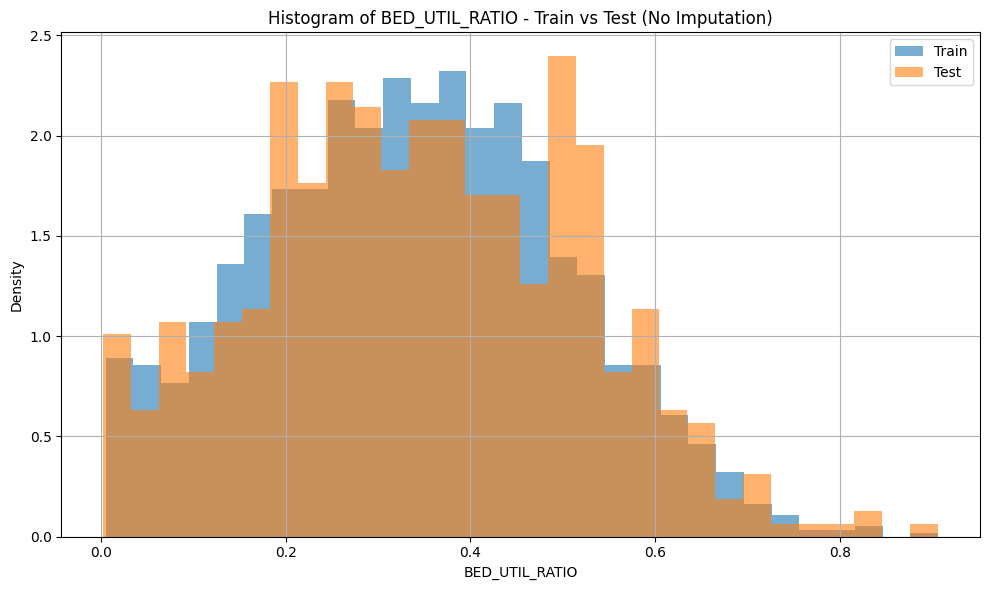

In [ ]:
# === Histogram of Bed_util_ratio - Train vs Test (No Imputation) ===
plt.figure(figsize=(10, 6))
plt.hist(train_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Train", density=True)
plt.hist(test_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Test", density=True)
plt.title("Histogram of BED_UTIL_RATIO - Train vs Test (No Imputation)")
plt.xlabel("BED_UTIL_RATIO")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### BarPlot - Imputation Comparison for Is_Metro_Micro

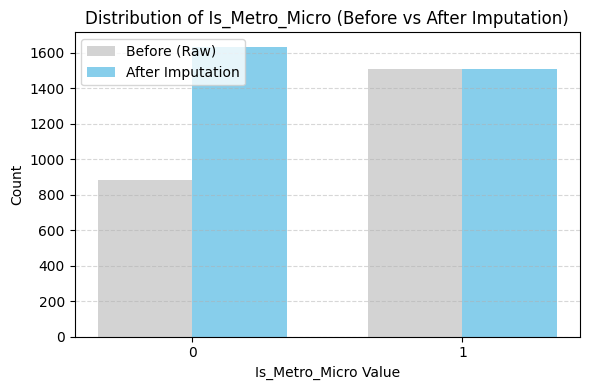

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Before imputation: include NaNs
before = df_cleaned["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan}).value_counts(dropna=False)
before.index = before.index.astype("object")  # so NaN label is retained

# After imputation: should be only 0 and 1
after = df_final_full["Is_Metro_Micro"].value_counts()

# Align both to 0 and 1 only (for bar chart)
x_labels = [0, 1]
before_aligned = [before.get(0, 0), before.get(1, 0)]
after_aligned = [after.get(0, 0), after.get(1, 0)]

# Plot
bar_width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, before_aligned, width=bar_width, label="Before (Raw)", color="lightgray")
plt.bar(x + bar_width/2, after_aligned, width=bar_width, label="After Imputation", color="skyblue")

plt.xticks(ticks=x, labels=["0", "1"])
plt.xlabel("Is_Metro_Micro Value")
plt.ylabel("Count")
plt.title("Distribution of Is_Metro_Micro (Before vs After Imputation)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Shapiro-Wilk W Statistic for BED_UTIL_RATIO

In [ ]:
from scipy.stats import shapiro

# Run only on non-null values
target_values = df_final_full["Bed_util_ratio"].dropna()

# Perform Shapiro-Wilk test
stat, p = shapiro(target_values)

print("Shapiro-Wilk W Statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")


Shapiro-Wilk W Statistic: 0.9919237932068726
p-value: 2.821064526072581e-10
Target likely not normally distributed (reject H0)


In [ ]:
Shapiro_Result = """We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. \nThe resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. \nThis insight may inform downstream modeling choices (e.g., transformation before regularized regression). \nSince our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), \nwe retained the raw distribution of the target for now."""
print(Shapiro_Result)

We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. 
The resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. 
This insight may inform downstream modeling choices (e.g., transformation before regularized regression). 
Since our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), 
we retained the raw distribution of the target for now.


### Distribution of BED_UTIL_RATIO w/ KDE

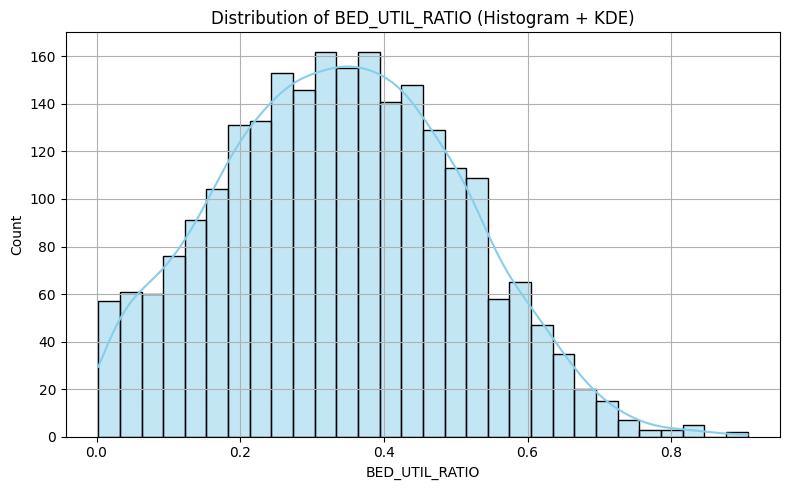

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(bed_util_values, kde=True, bins=30, color="skyblue")
plt.title("Distribution of BED_UTIL_RATIO (Histogram + KDE)")
plt.xlabel("BED_UTIL_RATIO")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### Q-Q Plot for Normality Check

<Figure size 600x600 with 0 Axes>

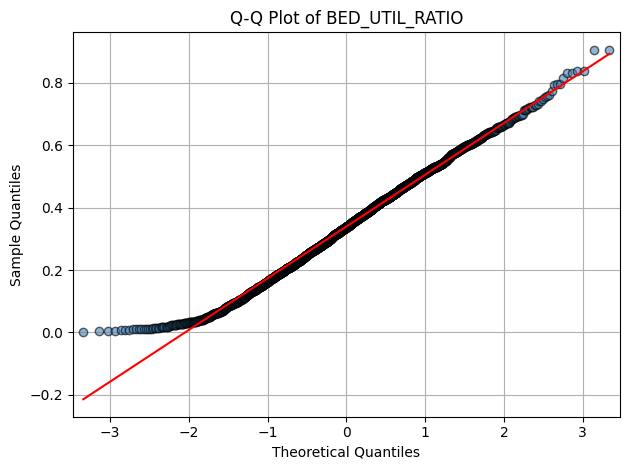

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# QQ plot
plt.figure(figsize=(6, 6))
sm.qqplot(bed_util_values, line="s", markerfacecolor='steelblue', markeredgecolor='black', alpha=0.6)
plt.title("Q-Q Plot of BED_UTIL_RATIO")
plt.grid(True)
plt.tight_layout()
plt.show()
